In [1]:
import torch
import torchvision
import os
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
#dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
#download_url(dataset_url, '.')

In [3]:
# Extract from archive
#with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#    tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['bird', 'deer', 'cat', 'truck', 'frog', 'dog', 'ship', 'automobile', 'airplane', 'horse']


In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print("num element=", len(airplane_files))
print(airplane_files[:5])

num element= 5000
['3111.png', '2107.png', '2901.png', '1075.png', '3570.png']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
dataset = ImageFolder(data_dir + "/train", transform=ToTensor())

In [8]:
# we need to change dimensions in order to show the image: 
# we need to put the first dimension at the end
def show(img, label):
    print(img.shape, label)
    plt.imshow(img.permute(1,2,0))

torch.Size([3, 32, 32]) 0


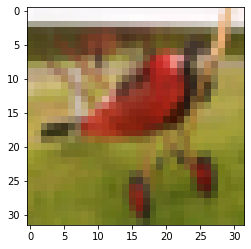

In [9]:
show(*dataset[2])

# Train and validation dataset

In [10]:
import numpy as np

def split_indices(n, val_percentage=0.1, seed=90):
    n_val = int(n*val_percentage)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [11]:
val_percentage = 0.2
rand_seed = 42
train_idxs, val_idxs = split_indices(len(dataset), val_percentage, rand_seed)
print(len(train_idxs), len(val_idxs))

40000 10000


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size=100
train_sampler = SubsetRandomSampler(train_idxs) # this create an obj that takes ndices from the subset
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler) # load data in batches
#takes batches of 100 images from the subset of indices given by SubsetRandomSampler

val_sampler = SubsetRandomSampler(val_idxs)
val_dl = DataLoader(dataset, batch_size, sampler=val_sampler)


In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for imgs, labs in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(imgs, 10).permute(1,2,0))
        break

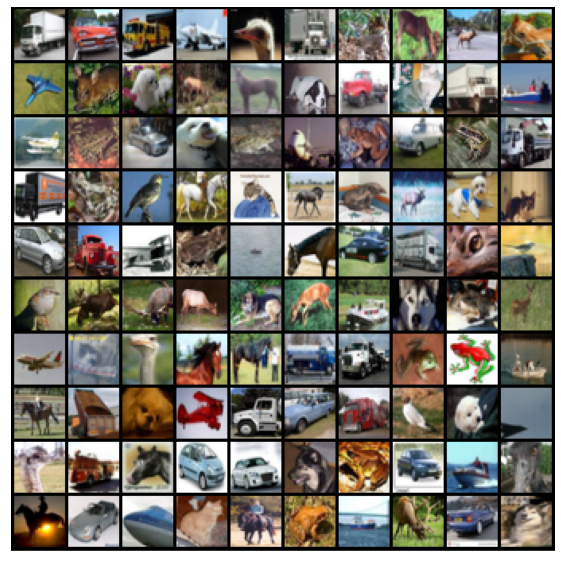

In [14]:
show_batch(train_dl)

# Defining the model

* less parameters
* each output element depends on a small input of elements
* parameter sharing and spatial invariance

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
num_channels_in = 3
num_channels_out = 8
# padding to avoid losing image size

simple_model = nn.Sequential(
    #increase num channels
    nn.Conv2d(num_channels_in, num_channels_out, kernel_size=3, stride=1, padding=1),
    # makes image smaller
    nn.MaxPool2d(2,2)
)
# if I have 16 channels out, means that I have to find 16 different kernels and weights to apply to my channels (and sum the results)
#The Conv2d layer transforms a 3-channel image to a 16-channel feature map, 
#and the MaxPool2d layer halves the height and width. 

In [17]:
for imgs, labels in train_dl:
    print(imgs.shape)
    outs = simple_model(imgs)
    print(outs.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100, 8, 16, 16])


In [18]:
model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

In [20]:
model[0].weight.shape
#3x3 kernel size. each of those kernel has 3 channels as input, and those are applied to obtain 32 images 

torch.Size([32, 3, 3, 3])

torch.Size([100, 3, 32, 32])
torch.Size([100, 10])
tensor([-0.0273,  0.0245, -0.0399,  0.0391, -0.0260,  0.0312,  0.0219,  0.0385,
         0.0256, -0.0317], grad_fn=<SelectBackward>)
tensor([0.0967, 0.1019, 0.0955, 0.1034, 0.0968, 0.1025, 0.1016, 0.1033, 0.1020,
        0.0963], grad_fn=<SoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)
tensor(0.1034, grad_fn=<MaxBackward1>)
torch.Size([3, 32, 32]) tensor(6)


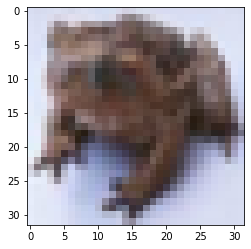

In [21]:
for imgs, labels in train_dl:
    print(imgs.shape)
    outs = model(imgs)
    print(outs.shape)
    print(outs[0])
    probs = F.softmax(outs[0], dim=0)
    print(probs)
    print(torch.sum(probs))
    print(torch.max(probs))
    show(imgs[0], labels[0])
    break

torch.Size([3, 32, 32]) tensor(6)
tensor([0.0967, 0.1019, 0.0955, 0.1034, 0.0968, 0.1025, 0.1016, 0.1033, 0.1020,
        0.0963], grad_fn=<SoftmaxBackward>)
actual label= tensor(6)


'ship'

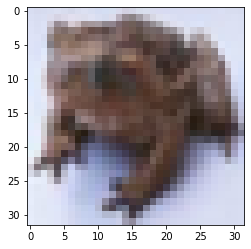

In [22]:
show(imgs[0], labels[0])
probs = F.softmax(outs[0], dim=0)
print(probs)
torch.max(probs)
classes[2]
print("actual label=", labels[0])
classes[labels[0]]

In [23]:
def get_defauls_device():
    
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [24]:
# to avoid put all stuff on gpu at once
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_defauls_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=4096, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Linea

In [26]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
    
    pred = model(xb)
    loss = loss_fn(pred, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(pred, yb)
        
    return loss, len(xb), metric_result

def evaluation(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results =[ loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        
    losses, nums, metric_result = zip(*results)
    total = np.sum(nums)
    avg_losses = np.sum(np.multiply(losses, nums))/total
    
    avg_metric = None
    if metric is not None:
        avg_metric = np.sum(np.multiply(metric_result, nums))/total
        
    return avg_losses, total, avg_metric

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item()/len(preds))
    return acc

In [38]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_fn=None, lr=None, metric=None):
    
    train_losses, val_losses, val_metrics = [],  [], []
    
    if opt_fn is None:
        opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        
        #Training
        #i=0
        print("Train")
        model.train() # setting to sa to pytorch what we ar doing
        for xb, yb in train_dl:
            #print('i=', i)
            #i+=1
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt, metric)
        
        # Evaluation
        print("Eval")
        #model.evaluation()
        avg_eval_loss, total, avg_metric = evaluation(model, loss_fn, valid_dl, metric)
        
        train_losses.append(train_loss)
        val_losses.append(avg_eval_loss)
        val_metrics.append(avg_metric)
        
        if metric is None:
            print("Epoch=", epoch, "train loss=", train_losses, "val_loss=", val_loss)
        else:
            print("Epoch=", epoch, "train loss=", train_losses, "val_loss=", val_loss, "matric value=", val_metrics)
            
    return train_losses, val_losses, val_metrics

In [30]:
val_loss, _, val_acc = evaluation(model, F.cross_entropy, val_dl, metric=accuracy)

In [31]:
print(val_loss, val_acc)

2.302915146350861 0.10079999964684248


In [39]:
epochs = 3
lr = 0.05
loss_fn = F.cross_entropy
opt_fn = torch.optim.Adam

fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn=opt_fn, lr=lr, metric=accuracy)

Train
Eval
Epoch= 0 train loss= [tensor(2.2915, grad_fn=<NllLossBackward>)] val_loss= 2.302915146350861 matric value= [0.09850000033155083]
Train
Eval
Epoch= 1 train loss= [tensor(2.2915, grad_fn=<NllLossBackward>), tensor(2.3068, grad_fn=<NllLossBackward>)] val_loss= 2.302915146350861 matric value= [0.09850000033155083, 0.0955000001937151]
Train
Eval
Epoch= 2 train loss= [tensor(2.2915, grad_fn=<NllLossBackward>), tensor(2.3068, grad_fn=<NllLossBackward>), tensor(2.3017, grad_fn=<NllLossBackward>)] val_loss= 2.302915146350861 matric value= [0.09850000033155083, 0.0955000001937151, 0.1029999997280538]


([tensor(2.2915, grad_fn=<NllLossBackward>),
  tensor(2.3068, grad_fn=<NllLossBackward>),
  tensor(2.3017, grad_fn=<NllLossBackward>)],
 [2.30688720703125, 2.306224069595337, 2.305931017398834],
 [0.09850000033155083, 0.0955000001937151, 0.1029999997280538])

# Visual Test

In [40]:
test_ds = ImageFolder(data_dir+"/test", transform=ToTensor())

In [41]:
def predict_imgs(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb.to(device))
    _, pred = torch.max(yb, dim=1)
    return dataset.classes[pred[0].item()]

'dog'

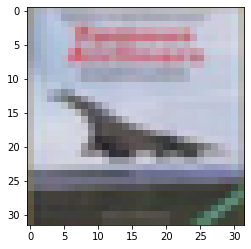

In [42]:
img, label = test_ds[0]
plt.imshow(img.permute(1,2,0))
predict_imgs(img, model)

'dog'

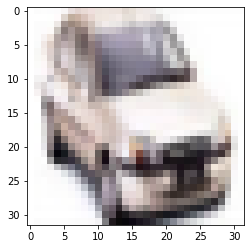

In [43]:
img, label = test_ds[1234]
plt.imshow(img.permute(1,2,0))
predict_imgs(img, model)

'dog'

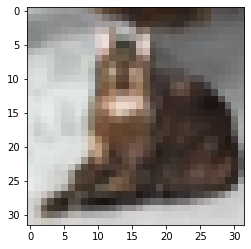

In [44]:
img, label = test_ds[3432]
plt.imshow(img.permute(1,2,0))
predict_imgs(img, model)

# Testing the model

In [ ]:
test_loader = DataLoader(test_ds, batch_size)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
test_loss, _, test_acc = evaluation(model, F.cross_entropy, test_loader, metric=accuracy)

In [ ]:
print(test_loss, test_acc)

# Save the model

In [ ]:
torch.save(model.state_dict(), 'cifar10-first-trial.pth')

# Load the model

In [ ]:
model2 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

In [ ]:
model2.load_state_dict(torch.load('cifar10-first-trial.pth'))

In [ ]:
# check if test accuracy is the same
test_loss2, _, test_acc2 = evaluation(model2, F.cross_entropy, test_loader, metric=accuracy)

In [ ]:
print(test_loss, test_acc)